# Dimensionality Discussion and Reduction
Task: Analyze the dimensionality of your dataset and propose methods to reduce it.

Requirements:

In a notebook (notebooks/Dimensionality_Reduction.ipynb):

- Discuss the current dimensions of the dataset and any challenges they present (e.g., high dimensionality, sparse data).

- Propose and implement at least two dimensionality reduction techniques:

- Feature extraction techniques like PCA (Principal Component Analysis).

- Non-linear methods like t-SNE (t-Distributed Stochastic Neighbor Embedding).

- Visualize the results of dimensionality reduction (scatter plots, explained variance charts).

- Discuss the implications of dimensionality reduction on your dataset.

In [ ]:
# the high dimensionality of the data, particularly in the sentinel-2 bands will provide a lot of redundancy
# there's a lot of opportunities to reduce the dimensionality of the data when it comes to indices
# for example, spectral indices like NDSI and NDWI will likely capture a lot of information in the green and NIR bands
# and there are more indices to capture information in other combinations of bands for sentinel-2

# the same goes for elevation (TPI and slope and aspect will be able to account for many of the other variables)

# the hard part of this dataset is spatial autocorrelation as we don't want to remove full sites of data, though

# here, we use PCA and TSNE for dimensionality reduction, PCE as a preliminary look into how to reduce our massive dataset
# and TSNE to see further into the clusters and variance

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import pandas as pd

import deep_snow.dataset

In [2]:
# grab data paths
data_dir = '/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/subsets_v4/train'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')

In [3]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

In [4]:
train_data = deep_snow.dataset.Dataset(path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)

In [5]:
# let's just look into one training file
for i, data_tuple in enumerate(train_loader):
    data_dict = {name: tensor.squeeze() for name, tensor in zip(selected_channels, data_tuple)}
    break

In [6]:
# Convert each tensor in the dictionary to a NumPy array
data_dict_np = {key: tensor.numpy().flatten() for key, tensor in data_dict.items()}
# Convert dictionary to DataFrame
df = pd.DataFrame(data_dict_np)

In [19]:
df.shape

(16384, 38)

Explained variance ratio: [0.6590237  0.07840464 0.05483955 0.05326708 0.04034574]


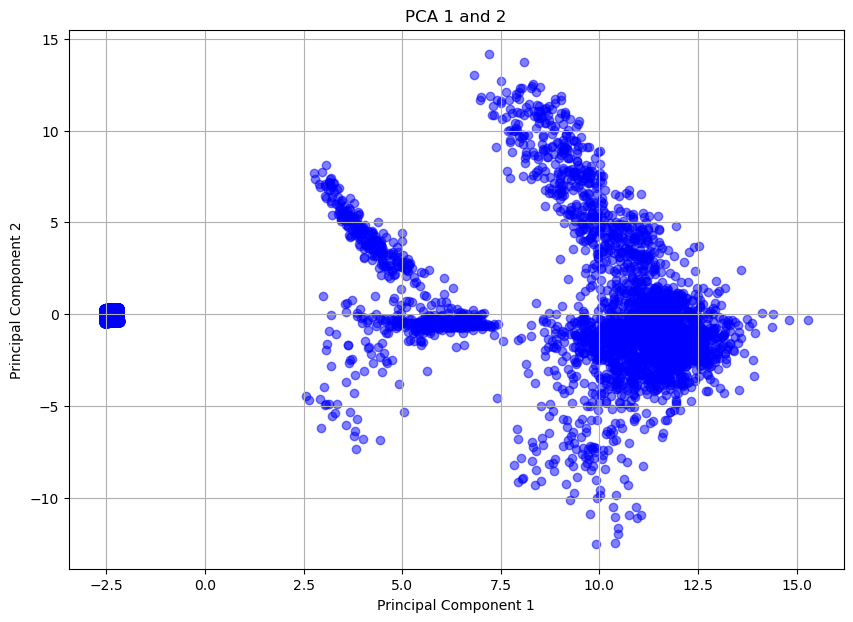

In [12]:
# PCA time
# I won't do this for every file due to computation time but here's for one file
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Standardize the data before applying PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
# Apply PCA
pca = PCA(n_components=5)
df_pca = pca.fit_transform(df_scaled)
# Display the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c='blue', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA 1 and 2')
plt.grid(True)
plt.show()

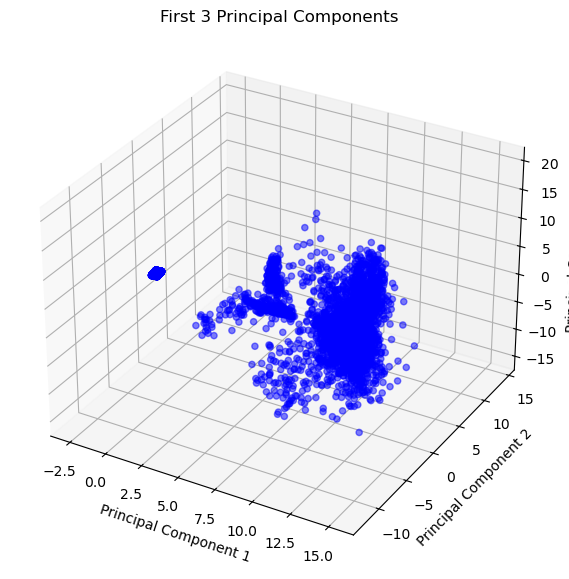

In [10]:
from mpl_toolkits.mplot3d import Axes3D
# Plot the PCA results in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c='blue', alpha=0.5)
# Label the axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
# Title and grid
ax.set_title('First 3 Principal Components')
ax.grid(True)
# Show plot
plt.show()

In [ ]:
from sklearn.manifold import TSNE
# Assuming df_pca is the PCA-transformed data you obtained earlier
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
df_tsne = tsne.fit_transform(df_pca)

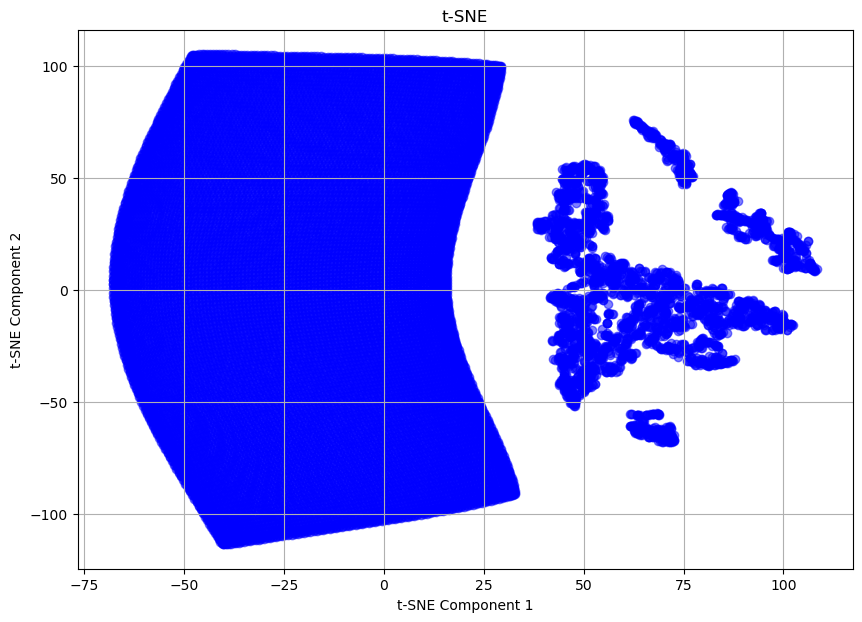

In [14]:
# Plot the t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c='blue', alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE')
plt.grid(True)
plt.show()

In [ ]:
# as we can see from our PCA and TSNE plots there is a TON of variation and clustering happening with our data
# this shows us that running feature extraction and re-running this analysis is crucial as seen in EDA.ipynb as well
# otherwise, there's not much else to say about these plots besides we need to conduct robust feature analysis/extraction
# before we even think about implementing PCA and TSNE